#**“BrickVision: Real-Time LEGO Brick Classification with Gradio UI”**

---
##Objective:

Building a beginner-friendly computer vision app that identifies LEGO brick types from images using a YOLOv8 classification model, trained on the Kaggle dataset pacogarciam3/lego-brick-sorting-image-recognition.

It will:

1. Download the dataset programmatically

2. Create a smaller, balanced subset .

3. Train a YOLOv8 classifier

4. Provide a web UI to upload images and get predictions

---



* **Install libraries & check device**

---
*Installs required packages and checks if CUDA (GPU) is available.*



In [1]:
%pip -q install kagglehub ultralytics datasets gradio pandas matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.4 MB/s eta 0:00:00


In [2]:
import os, glob, random, shutil, zipfile, tarfile, pathlib
from pathlib import Path
random.seed(1337)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


* **Downloading the Kaggle dataset via kagglehub**


---
*Downloads pacogarciam3/lego-brick-sorting-image-recognition into a local  folder.*

In [3]:
import kagglehub

# Downloading latest version of the dataset
kaggle_path = kagglehub.dataset_download("pacogarciam3/lego-brick-sorting-image-recognition")
print("Kaggle dataset downloaded to:", kaggle_path)

# Exploring what we got
print("Files in dataset root:")
for p in sorted(Path(kaggle_path).glob("*")):
    print(" -", p.name)

100%|██████████| 616M/616M [00:06<00:00, 102MB/s] 

Extracting files...


Kaggle dataset downloaded to: /root/.cache/kagglehub/datasets/pacogarciam3/lego-brick-sorting-image-recognition/versions/4
Files in dataset root:
 - Base Images
 - Cropped Images
 - ImageSetKey.csv
 - Image_Count_Summary.jpg
 - background_backlit_A.jpg
 - background_backlit_B.jpg
 - base images
 - cropped images
 - example_1_Cropped Image.jpg
 - example_2_Base Image.jpg


* **Unpack any archives inside the dataset folder**

---
* *Some Kaggle datasets are zipped inside; this unpacks .zip*

* *This function’s purpose is to automatically find and extract compressed archives (like .zip and .tar-based formats) inside a given folder, including all subfolders*

In [4]:
def safe_extract_all(root: Path):
    root = Path(root)
    for p in root.rglob("*"):
        if p.suffix.lower() in {".zip"}:
            print("Unzipping:", p)
            with zipfile.ZipFile(p, 'r') as zf:
                zf.extractall(p.parent)
        elif p.suffix.lower() in {".tar", ".gz", ".tgz", ".bz2", ".xz"}:

            try:
                print("Untarring:", p)
                with tarfile.open(p, 'r:*') as tf:
                    tf.extractall(p.parent)
            except Exception as e:
                print("Skipping tar:", p, e)

In [5]:
safe_extract_all(Path(kaggle_path))

print("\nAfter unpacking, top-level tree:")
for p in sorted(Path(kaggle_path).glob("*")):
    print(" -", p.name)


After unpacking, top-level tree:
 - Base Images
 - Cropped Images
 - ImageSetKey.csv
 - Image_Count_Summary.jpg
 - background_backlit_A.jpg
 - background_backlit_B.jpg
 - base images
 - cropped images
 - example_1_Cropped Image.jpg
 - example_2_Base Image.jpg


* **Building a smaller YOLO classification dataset**

---

*Colab storage can fill up (an issue I came across using dataset from a different source). This caps the number of images per class and creates train/val/test folders that YOLO expects.*

In [6]:
from PIL import Image
from collections import defaultdict
import math

In [7]:
MAX_PER_CLASS = 120
VAL_FRACTION = 0.15
TEST_FRACTION = 0.15

In [8]:
RC_ROOT = Path(kaggle_path)
DEST_ROOT = Path("/content/datasets/lego_cls")

*The Following code:*

---

* *Clears and recreates a destination folder (DEST_ROOT) with subdirectories for "train", "val", and "test".*

* *Scans through a given directory tree to find a folder that looks like a "class-based dataset" — meaning:*

 1. *It contains multiple subfolders (classes).*

 2. *Each subfolder has at least one image file.*

* *Returns the path to the first matching folder or None if none found.*



In [9]:
if DEST_ROOT.exists():
    shutil.rmtree(DEST_ROOT)
for s in ["train","val","test"]:
    (DEST_ROOT / s).mkdir(parents=True, exist_ok=True)

def find_class_dirs(root: Path, min_classes=2):
    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    for candidate in [root] + [p for p in root.rglob("*") if p.is_dir()]:
        subdirs = [d for d in candidate.iterdir() if d.is_dir()]
        if len(subdirs) < min_classes:
            continue
        # Checking if subdirs contain images
        ok = 0
        for sd in subdirs:
            imgs = [f for f in sd.glob("*") if f.suffix.lower() in exts]
            if len(imgs) > 0:
                ok += 1
        if ok >= min_classes:
            return candidate
    return None


In [10]:
cls_root = find_class_dirs(RC_ROOT)
assert cls_root is not None, "Could not auto-detect a <folder-per-class> structure in the Kaggle dataset."

print("Detected class root:", cls_root)

Detected class root: /root/.cache/kagglehub/datasets/pacogarciam3/lego-brick-sorting-image-recognition/versions/4/cropped images


*Gathering images per class and cap to MAX_PER_CLASS*

In [11]:
exts = {".jpg",".jpeg",".png",".bmp",".webp"}
class_to_paths = defaultdict(list)
for class_dir in sorted([d for d in cls_root.iterdir() if d.is_dir()]):
    cname = class_dir.name
    imgs = [p for p in class_dir.rglob("*") if p.suffix.lower() in exts]
    if imgs:
        class_to_paths[cname].extend(imgs)

*Splitting each class into train/val/test and save as normalized RGB JPGs*

In [12]:
for cname, paths in class_to_paths.items():
    random.shuffle(paths)
    selected = paths[:MAX_PER_CLASS]

    n = len(selected)
    n_val = max(1, int(round(n * VAL_FRACTION)))
    n_test = max(1, int(round(n * TEST_FRACTION)))
    n_train = max(1, n - n_val - n_test)

    splits = {
        "train": selected[:n_train],
        "val"  : selected[n_train:n_train+n_val],
        "test" : selected[n_train+n_val:n_train+n_val+n_test]
    }
    for split, files_ in splits.items():
        out_dir = DEST_ROOT / split / cname
        out_dir.mkdir(parents=True, exist_ok=True)
        for i, src in enumerate(files_):
            # Convert to RGB JPG to normalize formats
            try:
                im = Image.open(src).convert("RGB")
                im.save(out_dir / f"{i:06d}.jpg", quality=90)
            except Exception as e:
                # Skip unreadable images
                pass

print("Built smaller dataset at:", DEST_ROOT)

Built smaller dataset at: /content/datasets/lego_cls


* **Sanity check**

----
*Prints how many images per class in each split and shows a quick image grid.*

In [13]:
import matplotlib.pyplot as plt
import cv2

In [14]:
for split in ["train","val","test"]:
    p = DEST_ROOT / split
    if p.exists():
        classes = sorted([d.name for d in p.iterdir() if d.is_dir()])
        print(f"{split}: {len(classes)} classes")
        for c in classes[:10]:
            count = len(list((p/c).glob("*")))
            print(f"  {c}: {count} images")

train: 20 classes
  Brick_1x1: 84 images
  Brick_1x2: 84 images
  Brick_1x3: 84 images
  Brick_1x4: 84 images
  Brick_2x2: 84 images
  Brick_2x2_L: 84 images
  Brick_2x2_Slope: 84 images
  Brick_2x3: 84 images
  Brick_2x4: 84 images
  Plate_1x1: 84 images
val: 20 classes
  Brick_1x1: 18 images
  Brick_1x2: 18 images
  Brick_1x3: 18 images
  Brick_1x4: 18 images
  Brick_2x2: 18 images
  Brick_2x2_L: 18 images
  Brick_2x2_Slope: 18 images
  Brick_2x3: 18 images
  Brick_2x4: 18 images
  Plate_1x1: 18 images
test: 20 classes
  Brick_1x1: 18 images
  Brick_1x2: 18 images
  Brick_1x3: 18 images
  Brick_1x4: 18 images
  Brick_2x2: 18 images
  Brick_2x2_L: 18 images
  Brick_2x2_Slope: 18 images
  Brick_2x3: 18 images
  Brick_2x4: 18 images
  Plate_1x1: 18 images


*Visualising small grid from train*

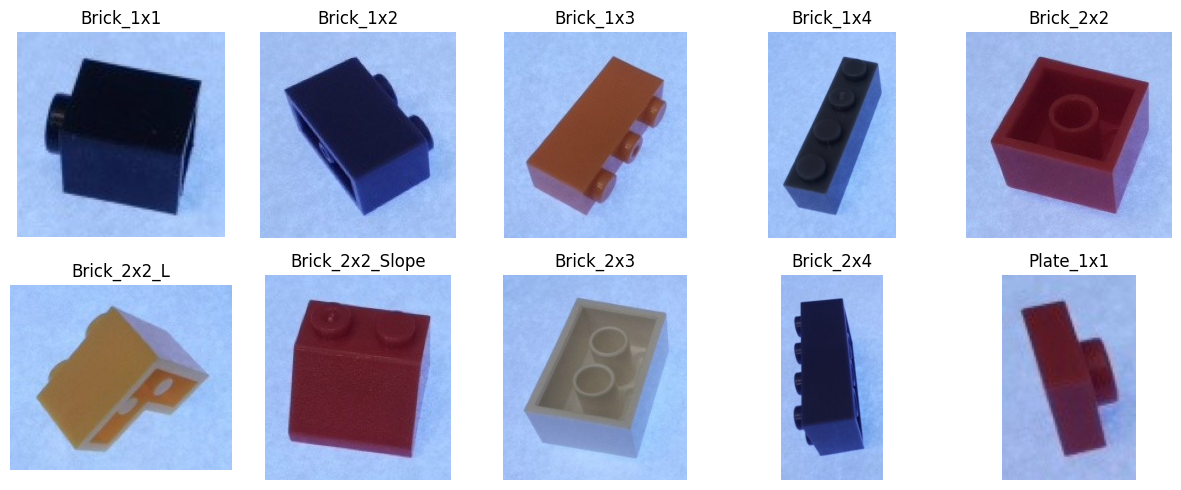

In [15]:
train_dir = DEST_ROOT / "train"
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])

fig, axes = plt.subplots(2, 5, figsize=(12,5))
axes = axes.flatten()
samples = []
for c in classes:
    files = list((train_dir / c).glob("*"))
    if files:
        samples.append(random.choice(files))
samples = samples[:len(axes)]
for ax, fp in zip(axes, samples):
    img = cv2.imread(str(fp))
    if img is None:
        ax.axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(Path(fp).parent.name)
    ax.axis('off')
plt.tight_layout()
plt.show()

* **Training YOLOv8 classification model**

---

*Training a classifier using your train/val folders.*

* *yolov8n-cls.pt is the “nano” model (faster).*

* *On CPU,reduced batch and epochs to keep it practical.*

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")
results = model.train(
    data=str(DEST_ROOT),
    epochs=20 if device=="cuda" else 12,
    imgsz=224,
    batch=32 if device=="cuda" else 8,
    workers=0 if device!="cuda" else 8,
    verbose=True
)

print("Training complete.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/lego_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

train: Scanning /content/datasets/lego_cls/train... 1680 images, 0 corrupt: 100%|██████████| 1680/1680 [00:00<00:00, 3852.49it/s]

train: New cache created: /content/datasets/lego_cls/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 95.6±58.4 MB/s, size: 3.3 KB)



val: Scanning /content/datasets/lego_cls/val... 360 images, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 4110.72it/s]

val: New cache created: /content/datasets/lego_cls/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12         0G      3.079          8        224:   0%|          | 1/210 [00:01<04:36,  1.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]

                   all      0.381      0.806



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]

                   all      0.583      0.925



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]

                   all       0.65      0.981



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]

                   all      0.753      0.983



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]

                   all      0.792      0.989



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


                   all      0.858      0.989

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]

                   all      0.831      0.992



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]

                   all      0.853      0.997



      Epoch    GPU_mem       loss  Instances       Size


      10/12         0G     0.6127          8        224: 100%|██████████| 210/210 [02:04<00:00,  1.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]

                   all      0.889      0.997



      Epoch    GPU_mem       loss  Instances       Size


      11/12         0G      0.603          8        224: 100%|██████████| 210/210 [02:04<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]

                   all      0.861      0.997



      Epoch    GPU_mem       loss  Instances       Size


      12/12         0G     0.5837          8        224: 100%|██████████| 210/210 [02:04<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.68it/s]

                   all      0.906          1



12 epochs completed in 0.449 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,460,500 parameters, 0 gradients, 3.3 GFLOPs
train: /content/datasets/lego_cls/train... found 1680 images in 20 classes ✅ 
val: /content/datasets/lego_cls/val... found 360 images in 20 classes ✅ 
test: /content/datasets/lego_cls/test... found 360 images in 20 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all      0.906          1
Speed: 0.0ms preprocess, 17.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Training complete.


* **Evaluate**

---

 *Printing validation (and test) metrics: accuracy, etc.*

In [17]:
val_metrics = model.val(split="val")
print("Val metrics:", val_metrics)

test_dir = DEST_ROOT / "test"
if test_dir.exists():
    test_metrics = model.val(split="test")
    print("Test metrics:", test_metrics)
else:
    print("No test/ split present — skipped explicit test.")

Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,460,500 parameters, 0 gradients, 3.3 GFLOPs
train: /content/datasets/lego_cls/train... found 1680 images in 20 classes ✅ 
val: /content/datasets/lego_cls/val... found 360 images in 20 classes ✅ 
test: /content/datasets/lego_cls/test... found 360 images in 20 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 50.2±39.8 MB/s, size: 3.3 KB)


val: Scanning /content/datasets/lego_cls/val... 360 images, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:08<00:00,  5.25it/s]


                   all      0.906          1
Speed: 0.0ms preprocess, 17.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Val metrics: ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d79831664d0>
curves: []
curves_results: []
fitness: 0.952777773141861
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9055555462837219, 'metrics/accuracy_top5': 1.0, 'fitness': 0.952777773141861}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.003936619451552461, 'inference': 17.76900860278753, 'loss': 0.0002747888781110911, 'postprocess': 0.0007549083294280637}
task: 'classify'
top1: 0.9055555462837219
top5: 1.0
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
train: /content/datasets/lego_cls/train... found 1680 images in 20 classes ✅ 
val: /content/datasets/lego_cls/va

test: Scanning /content/datasets/lego_cls/test... 360 images, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 2857.11it/s]

test: New cache created: /content/datasets/lego_cls/test.cache



               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:08<00:00,  5.28it/s]


                   all      0.903      0.994
Speed: 0.0ms preprocess, 17.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3
Test metrics: ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d798bd2ef10>
curves: []
curves_results: []
fitness: 0.9486111104488373
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9027777910232544, 'metrics/accuracy_top5': 0.9944444298744202, 'fitness': 0.9486111104488373}
save_dir: PosixPath('runs/classify/train3')
speed: {'preprocess': 0.003961955556203773, 'inference': 17.886676319451706, 'loss': 0.000287149997449079, 'postprocess': 0.0006505222245323239}
task: 'classify'
top1: 0.9027777910232544
top5: 0.9944444298744202


* **Single-image prediction**

---

*Picks a random image and prints top-3 predicted classes with probabilities.*



In [18]:
import random
candidates = list((DEST_ROOT/"test").glob("*/*")) if (DEST_ROOT/"test").exists() \
             else list((DEST_ROOT/"val").glob("*/*"))
sample_img = str(random.choice(candidates))
print("Sample:", sample_img)

pred = model.predict(source=sample_img, imgsz=224)[0]

# Accessing top predictions using available attributes
top1_index = pred.probs.top1
top1_conf = pred.probs.top1conf
top5_indices = pred.probs.top5
top5_confs = pred.probs.top5conf

print(f"{model.names[top1_index]}: {float(top1_conf):.3f}")

# Print the top 2 from the top 5 (excluding top 1)
for i in range(min(2, len(top5_indices) - 1)):
    index = top5_indices[i+1]
    conf = top5_confs[i+1]
    print(f"{model.names[index]}: {float(conf):.3f}")

Sample: /content/datasets/lego_cls/test/Plate_1x2_Grill/000011.jpg

image 1/1 /content/datasets/lego_cls/test/Plate_1x2_Grill/000011.jpg: 224x224 Plate_1x2_Grill 1.00, Plate_1x2 0.00, Plate_1x1_Slope 0.00, Brick_2x2_L 0.00, Brick_1x3 0.00, 45.9ms
Speed: 6.0ms preprocess, 45.9ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
Plate_1x2_Grill: 0.999
Plate_1x2: 0.000
Plate_1x1_Slope: 0.000


* **Gradio UI**

---

*Starts a simple web UI where you upload a brick image and see predicted class.*

In [19]:
import gradio as gr
from PIL import Image
import numpy as np

In [20]:
def predict_image(img: Image.Image):
    if img.mode != "RGB":
        img = img.convert("RGB")
    res = model.predict(source=img, imgsz=224)[0]

    probs = res.probs.data.cpu().numpy()
    class_names = [model.names[i] for i in range(len(probs))]
    return {name: float(prob) for name, prob in zip(class_names, probs)}

In [21]:
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload LEGO brick image"),
    outputs=gr.Label(num_top_classes=3, label="Predictions"),
    title="Brick-Vision: LEGO Brick Classifier (YOLOv8)",
    description="Trained on a reduced subset of pacogarciam3/lego-brick-sorting-image-recognition."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://08f3831bb7eb32689c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Steps

---

This notebook demonstrates how to build a real-time LEGO brick classification app using a YOLOv8 model and Gradio UI. The key steps are:

1.  **Install Libraries & Check Device:** Install necessary Python packages and determine if a GPU is available for training.
2.  **Download Kaggle Dataset:** Download the specified LEGO brick dataset from Kaggle using `kagglehub`.
3.  **Unpack Archives:** Extract any compressed files within the downloaded dataset.
4.  **Build Smaller Classification Dataset:** Create a smaller, balanced subset of the dataset for efficient training. This involves:
    *   Defining the maximum number of images per class.
    *   Splitting the data into training, validation, and testing sets.
    *   Converting images to a consistent format (RGB JPG).
5.  **Sanity Check:** Verify the dataset structure and content by printing image counts per class and visualizing a sample image grid.
6.  **Train YOLOv8 Classification Model:** Train a YOLOv8 classification model on the prepared dataset.
7.  **Evaluate Model:** Evaluate the trained model's performance on the validation and test sets by printing relevant metrics (top-1 and top-5 accuracy).
8.  **Single-Image Prediction:** Demonstrate how to use the trained model to make a prediction on a single image, showing the top predicted classes and their probabilities.
9.  **Gradio UI:** Build a simple web interface using Gradio to allow users to upload images and get real-time predictions from the model.

---
##Live Deployment

---

*To search for and list the best.pt model checkpoint files saved inside your YOLO classification training runs.*



In [22]:
import glob, os
cands = sorted(glob.glob("runs/classify/*/weights/best.pt"))
print("\n".join(cands) or "None found")

runs/classify/train/weights/best.pt


In [23]:
from google.colab import files
files.download(cands[-1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##***Here is the Link live app***

https://ghazna-brickvision-ai.hf.space